# Script to run LRP on Toy Model with XAUGs

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils
import pandas as pd

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm, SymLogNorm
from scipy import stats
#import h5py
import math
import time
import sklearn
from sklearn.utils import shuffle

import innvestigate
import innvestigate.utils as iutils

import os

1.13.1


In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.style.context('default')

In [4]:
grid=16

In [5]:
# testing data : 1,000,000 samples
data_test = np.load('data/jetImagesTest.npz')

In [7]:
def plot_MSE(filename, ax):
    hist = pd.read_csv(filename)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Square Error')
    ax.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,100])
    ax.legend()

In [8]:
def plot_acc(filename, ax):
    hist = pd.read_csv(filename)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Mean Square Error')
    ax.plot(hist['epoch'], hist['acc'],
           label='Train Accuracy')
    ax.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Accuracy')
#     plt.ylim([0,100])
    ax.legend()

Loading models

In [9]:
import keras
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model1 = load_model('model/CNN2D_XAUG_1mil_1.h5')
    model2 = load_model('model/CNN2D_XAUG_1mil_2.h5')
    model3 = load_model('model/CNN2D_XAUG_1mil_3.h5')
    model4 = load_model('model/CNN2D_XAUG_1mil_4.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


plotting model performance

In [11]:
test_input= [data_test['jetImages'], data_test['radii'], data_test['theta'], data_test['z'] ]

In [12]:
results_model1 = model1.evaluate(test_input, data_test['labels'])
results_model2 = model2.evaluate(test_input, data_test['labels'])
results_model3 = model3.evaluate(test_input, data_test['labels'])
results_model4 = model4.evaluate(test_input, data_test['labels'])

1000000/1000000 [==============================] - 119s 119us/step


In [13]:
np.set_printoptions(precision=4, suppress=True)
print("Model 1: ", results_model1)
print("Model 2: ", results_model2)
print("Model 3: ", results_model3)
print("Model 4: ", results_model4)

Model 1:  [0.006403301829699544, 0.0014876982368952855, 0.006403301829699544, 0.998168]
Model 2:  [0.006404464690567376, 0.0014909271666577143, 0.006404464690567376, 0.998135]
Model 3:  [0.006266188653423684, 0.0014839901563780786, 0.006266188653423684, 0.998159]
Model 4:  [0.0063222715705930025, 0.0014969888856478833, 0.0063222715705930025, 0.998158]


In [14]:
predict1 = model1.predict(test_input)
predict2 = model2.predict(test_input)
predict3 = model3.predict(test_input)
predict4 = model4.predict(test_input)

In [15]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(data_test['labels'][:,1], predict1[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(data_test['labels'][:,1], predict2[:,1])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds3 = roc_curve(data_test['labels'][:,1], predict3[:,1])
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, thresholds4 = roc_curve(data_test['labels'][:,1], predict4[:,1])
roc_auc4 = auc(fpr4, tpr4)

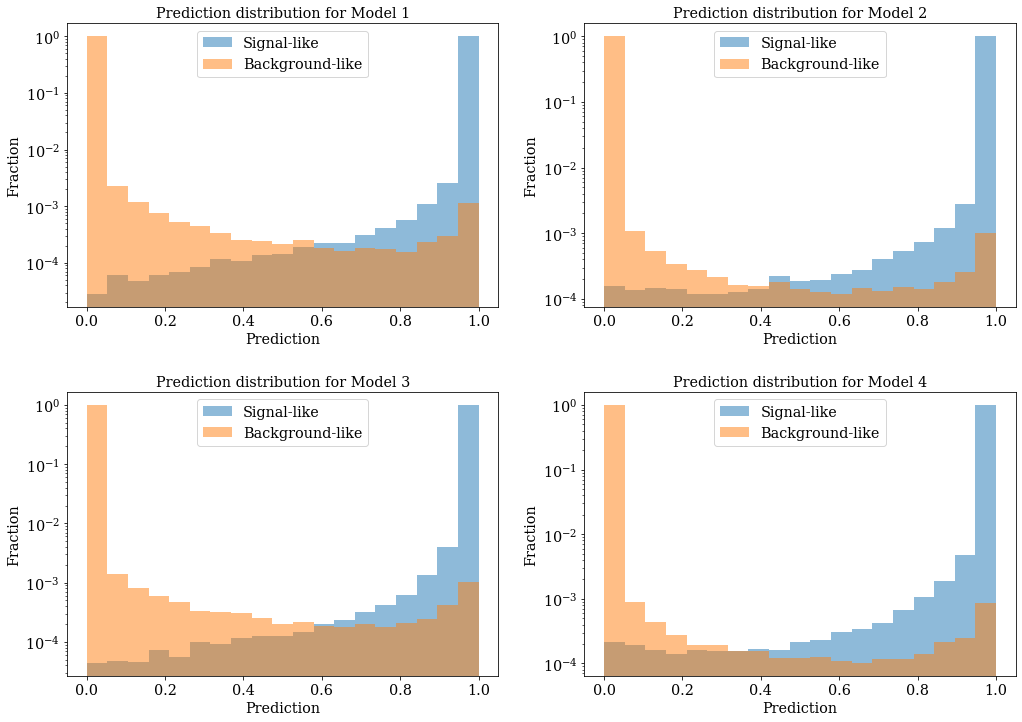

In [16]:
bins = np.linspace(0, 1, 20)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 12))
fig.subplots_adjust(wspace =0.2, hspace =0.3)
axs=axs.flatten()
    
for i in range(len(axs)):
    if i==0:
        sig = predict1[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict1[(data_test['labels'][:,0]==1)][:,1]
    elif i==1:
        sig = predict2[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict2[(data_test['labels'][:,0]==1)][:,1]
    elif i==2:
        sig = predict3[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict3[(data_test['labels'][:,0]==1)][:,1]
    else:
        sig = predict4[(data_test['labels'][:,1]==1)][:,1]
        bkg = predict4[(data_test['labels'][:,0]==1)][:,1]
    axs[i].hist(sig, bins, weights=np.ones(len(sig)) / len(sig), alpha=0.5, label='Signal-like')
    axs[i].hist(bkg, bins, weights=np.ones(len(bkg)) / len(bkg), alpha=0.5, label='Background-like')
    axs[i].legend(loc="best")
    axs[i].set_xlabel('Prediction')
    axs[i].set_ylabel('Fraction')
    axs[i].set_title('Prediction distribution for Model {}'.format(i+1))
    axs[i].set_yscale('log')
plt.show()
# fig.savefig('Toy_XAUG_predictionHist_multilodel.png', bbox_inches='tight')

# LRP

In [17]:
def GetRelevance(model, lrp_rule, data_image, data_var1, data_var2, data_var3):
    '''Inputs: model_name - keras.model,
               lrp_rule - str, data - array of shape (n, 1,grid,grid,1)'''
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    lrp_analyzer = innvestigate.create_analyzer(lrp_rule, model_ws)
    start = time.time()
    
    nElem = 20000
    batchsize = data_image.shape[0]
    slices = int(batchsize // nElem)
    size_from_loop = batchsize - (batchsize % nElem)

    print('Running LRP Analysis')
    print('Total Events: {0:0.0f}'.format(batchsize))
    print('Split into chunk size: {0:0.0f}'.format(nElem))
    print('Number of slices: ', slices)

    lrp = [lrp_analyzer.analyze([data_image[0:int(nElem)],
                                 data_var1[0:int(nElem)], 
                                 data_var2[0:int(nElem)],
                                 data_var3[0:int(nElem)]])]
    for i in range(1, slices):
        #if (i%10==0):
        print("... Running LRP on slice ",i)
        lrp_i = lrp_analyzer.analyze([data_image[int(nElem*i):int(nElem*(i+1))],
                                      data_var1[int(nElem*i):int(nElem*(i+1))], 
                                      data_var2[int(nElem*i):int(nElem*(i+1))],
                                      data_var3[int(nElem*i):int(nElem*(i+1))]])
        lrp.append(lrp_i)
        del lrp_i
        
    if((batchsize % nElem) > 0):
        print("... Running LRP remaining elements ", batchsize % nElem)
        lrp.append(lrp_analyzer.analyze([data_image[size_from_loop:],
                                         data_var1[size_from_loop:],
                                         data_var2[size_from_loop:],
                                         data_var3[size_from_loop:]]))
        slices = slices+1

    lrp_image =np.vstack([lrp[i][0] for i in range (slices)])
    lrp_xaugs =np.dstack((np.vstack([lrp[i][1] for i in range (slices)])[:,0],
                          np.vstack([lrp[i][1] for i in range (slices)])[:,1],
                          np.vstack([lrp[i][2] for i in range (slices)]).squeeze(),
                          np.vstack([lrp[i][3] for i in range (slices)]).squeeze()))#.reshape(batchsize, 4,1)
    print('time = ', time.time()-start, 's')
    return lrp_image, lrp_xaugs[0]

Uncomment the following 4 blocks to run and save LRP outputs for each model.

In [18]:
# im1, var1 = GetRelevance(model1, 'lrp.sequential_preset_a',
#                                data_test['jetImages'], data_test['radii'], 
#                                data_test['theta'], data_test['z'])
# np.savez('data/LRP_XAUG1', image = im1, var=var1)

Running LRP Analysis
Total Events: 1000000
Split into chunk size: 20000
Number of slices:  50
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
... Running LRP on slice  1
... Running LRP on slice  2
... Running LRP on slice  3
... Running LRP on slice  4
... Running LRP on slice  5
... Running LRP on slice  6
... Running LRP on slice  7
... Running LRP on slice  8
... Running LRP on slice  9
... Running LRP on slice  10
... Running LRP on slice  11
... Running LRP on slice  12
... Running LRP on slice  13
... Running LRP on slice  14
... Running LRP on slice  15
... Running LRP on slice  16
... Running LRP on slice  17
... Running LRP on slice  18
... Running LRP on slice  19
... Running LRP on slice  20
... Running LRP on slice  21
... Running LRP on slice  22
... Running LRP on slice  23
... Running LRP on slice  24
... Running LRP on slice  25
... Running LRP on slice  26
... Running LRP on slice  27
... Running LRP on slice  28
... Running LRP on slice 

In [20]:
# im2, var2 = GetRelevance(model2, 'lrp.sequential_preset_a',
#                                data_test['jetImages'], data_test['radii'], 
#                                data_test['theta'], data_test['z'])
# np.savez('data/LRP_XAUG2', image = im2, var=var2)

Running LRP Analysis
Total Events: 1000000
Split into chunk size: 20000
Number of slices:  50
... Running LRP on slice  1
... Running LRP on slice  2
... Running LRP on slice  3
... Running LRP on slice  4
... Running LRP on slice  5
... Running LRP on slice  6
... Running LRP on slice  7
... Running LRP on slice  8
... Running LRP on slice  9
... Running LRP on slice  10
... Running LRP on slice  11
... Running LRP on slice  12
... Running LRP on slice  13
... Running LRP on slice  14
... Running LRP on slice  15
... Running LRP on slice  16
... Running LRP on slice  17
... Running LRP on slice  18
... Running LRP on slice  19
... Running LRP on slice  20
... Running LRP on slice  21
... Running LRP on slice  22
... Running LRP on slice  23
... Running LRP on slice  24
... Running LRP on slice  25
... Running LRP on slice  26
... Running LRP on slice  27
... Running LRP on slice  28
... Running LRP on slice  29
... Running LRP on slice  30
... Running LRP on slice  31
... Running LRP 

In [21]:
# im3, var3 = GetRelevance(model3, 'lrp.sequential_preset_a',
#                                data_test['jetImages'], data_test['radii'], 
#                                data_test['theta'], data_test['z'])
# np.savez('data/LRP_XAUG3', image = im3, var=var3)

Running LRP Analysis
Total Events: 1000000
Split into chunk size: 20000
Number of slices:  50
... Running LRP on slice  1
... Running LRP on slice  2
... Running LRP on slice  3
... Running LRP on slice  4
... Running LRP on slice  5
... Running LRP on slice  6
... Running LRP on slice  7
... Running LRP on slice  8
... Running LRP on slice  9
... Running LRP on slice  10
... Running LRP on slice  11
... Running LRP on slice  12
... Running LRP on slice  13
... Running LRP on slice  14
... Running LRP on slice  15
... Running LRP on slice  16
... Running LRP on slice  17
... Running LRP on slice  18
... Running LRP on slice  19
... Running LRP on slice  20
... Running LRP on slice  21
... Running LRP on slice  22
... Running LRP on slice  23
... Running LRP on slice  24
... Running LRP on slice  25
... Running LRP on slice  26
... Running LRP on slice  27
... Running LRP on slice  28
... Running LRP on slice  29
... Running LRP on slice  30
... Running LRP on slice  31
... Running LRP 

In [22]:
# im4, var4 = GetRelevance(model4, 'lrp.sequential_preset_a',
#                                data_test['jetImages'], data_test['radii'], 
#                                data_test['theta'], data_test['z'])
# np.savez('data/LRP_XAUG4', image = im4, var=var4)

Running LRP Analysis
Total Events: 1000000
Split into chunk size: 20000
Number of slices:  50
... Running LRP on slice  1
... Running LRP on slice  2
... Running LRP on slice  3
... Running LRP on slice  4
... Running LRP on slice  5
... Running LRP on slice  6
... Running LRP on slice  7
... Running LRP on slice  8
... Running LRP on slice  9
... Running LRP on slice  10
... Running LRP on slice  11
... Running LRP on slice  12
... Running LRP on slice  13
... Running LRP on slice  14
... Running LRP on slice  15
... Running LRP on slice  16
... Running LRP on slice  17
... Running LRP on slice  18
... Running LRP on slice  19
... Running LRP on slice  20
... Running LRP on slice  21
... Running LRP on slice  22
... Running LRP on slice  23
... Running LRP on slice  24
... Running LRP on slice  25
... Running LRP on slice  26
... Running LRP on slice  27
... Running LRP on slice  28
... Running LRP on slice  29
... Running LRP on slice  30
... Running LRP on slice  31
... Running LRP 

Loading LRP scores for each model and normalising the relevance for each event to be b/w [-1,1]. For each event, we find the maximum absolute relevance (in image and XAUGs) and divide the relevances by that max value.

In [23]:
pixel_relevance = np.load('data/LRP_XAUG1.npz')
pixel_relevance2 = np.load('data/LRP_XAUG2.npz')
pixel_relevance3 = np.load('data/LRP_XAUG3.npz')
pixel_relevance4 = np.load('data/LRP_XAUG4.npz')

In [24]:
image_relevance = pixel_relevance['image']
var_relevance = pixel_relevance['var']

evemax = np.where(np.max(np.abs(image_relevance), axis=(1,2,3))> np.max(np.abs(var_relevance), axis=(1)),
                  np.max(np.abs(image_relevance), axis=(1,2,3)),
                  np.max(np.abs(var_relevance), axis=(1)))
evesum = np.sum(np.abs(image_relevance), axis =(1,2,3))+np.sum(np.abs(var_relevance), axis =(1))

In [25]:
norm_image_relevance1 = np.where(np.repeat(evemax,16*16).reshape(image_relevance.shape) >0,
                                (image_relevance/np.repeat(evemax,16*16).reshape(image_relevance.shape)),
                                0)

norm_var_relevance1 = np.where(np.repeat(evemax,4).reshape(var_relevance.shape) >0,
                                (var_relevance/np.repeat(evemax,4).reshape(var_relevance.shape)),
                                0)

In [26]:
image_relevance2 = pixel_relevance2['image']
var_relevance2 = pixel_relevance2['var']

evemax2 = np.where(np.max(np.abs(image_relevance2), axis=(1,2,3))> np.max(np.abs(var_relevance2), axis=(1)),
                  np.max(np.abs(image_relevance2), axis=(1,2,3)),
                  np.max(np.abs(var_relevance2), axis=(1)))
evesum2 = np.sum(np.abs(image_relevance2), axis =(1,2,3))+np.sum(np.abs(var_relevance2), axis=(1))

In [27]:
norm_image_relevance2 = np.where(np.repeat(evemax2,16*16).reshape(image_relevance2.shape) >0,
                                (image_relevance2/np.repeat(evemax2,16*16).reshape(image_relevance2.shape)),
                                0)

norm_var_relevance2 = np.where(np.repeat(evemax2,4).reshape(var_relevance2.shape) >0,
                                (var_relevance2/np.repeat(evemax2,4).reshape(var_relevance2.shape)),
                                0)

In [28]:
image_relevance3 = pixel_relevance3['image']
var_relevance3 = pixel_relevance3['var']

evemax3 = np.where(np.max(np.abs(image_relevance3), axis=(1,2,3))> np.max(np.abs(var_relevance3), axis=(1)),
                  np.max(np.abs(image_relevance3), axis=(1,2,3)),
                  np.max(np.abs(var_relevance3), axis=(1)))
evesum3 = np.sum(np.abs(image_relevance3), axis =(1,2,3))+np.sum(np.abs(var_relevance3), axis=(1))

In [29]:
norm_image_relevance3 = np.where(np.repeat(evemax3,16*16).reshape(image_relevance3.shape) >0,
                                (image_relevance3/np.repeat(evemax3,16*16).reshape(image_relevance3.shape)),
                                0)

norm_var_relevance3 = np.where(np.repeat(evemax3,4).reshape(var_relevance3.shape) >0,
                                (var_relevance3/np.repeat(evemax3,4).reshape(var_relevance3.shape)),
                                0)

In [30]:
image_relevance4 = pixel_relevance4['image']
var_relevance4 = pixel_relevance4['var']

evemax4 = np.where(np.max(np.abs(image_relevance4), axis=(1,2,3))> np.max(np.abs(var_relevance4), axis=(1)),
                  np.max(np.abs(image_relevance4), axis=(1,2,3)),
                  np.max(np.abs(var_relevance4), axis=(1)))
evesum4 = np.sum(np.abs(image_relevance4), axis =(1,2,3))+np.sum(np.abs(var_relevance4), axis=(1))

In [31]:
norm_image_relevance4 = np.where(np.repeat(evemax4,16*16).reshape(image_relevance4.shape) >0,
                                (image_relevance4/np.repeat(evemax4,16*16).reshape(image_relevance4.shape)),
                                0)

norm_var_relevance4 = np.where(np.repeat(evemax4,4).reshape(var_relevance4.shape) >0,
                                (var_relevance4/np.repeat(evemax4,4).reshape(var_relevance4.shape)),
                                0)

## Plotting

In [42]:
def draw_bubbleplot(relevance1, relevance2, relevance3, relevance4, xlabels, ylabels):
    
    '''
    Draws bubble plots for 4 models in a 2x2 plot.
    The relevance arrays should be of shape (number of events, number of variables) and
    should have been normalised on per event basis.
    For images create the relevance score by summing the eventwise normalised pixel relevances.
    xlabels: ['Image', 'Radius 1', 'Radius 2', r'$\theta$', 'z'] -> The variables
    ylabels: ['Rank 5', 'Rank 4', 'Rank 3', 'Rank 2', 'Rank 1'] -> Lowest rank closest to the horizontal axis
    '''
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    fig.subplots_adjust(wspace =0.3, hspace =0.3)
    axs=axs.flatten()
    x=(np.arange(len(xlabels))+1).tolist()
    for i in range(len(axs)):
        '''These ranks will be shown in reverse order i.e. 5 -> Rank1, 4-> Rank2, 3->Rank3, 2->Rank4, 1->Rank5'''
        if i==0:
            ranks = (relevance1.argsort(axis=1)+1)
        elif i==1:
            ranks = (relevance2.argsort(axis=1)+1)
        elif i==2:
            ranks = (relevance3.argsort(axis=1)+1)
        elif i==3:
            ranks = (relevance4.argsort(axis=1)+1)
        #print(ranks[0])
        xvals = np.array([x]*len(ranks))
        hist, xbins, ybins = np.histogram2d(xvals.flatten(), ranks.flatten(),
                                            bins=np.linspace(0.5, len(xlabels)+.5, len(xlabels)+1))
        #print(hist)
        X,Y = np.meshgrid(xbins[:-1]+0.5, ybins[:-1]+0.5)
        X = X[hist != 0]; Y = Y[hist != 0]
        Z = hist[hist != 0]

        im = axs[i].scatter(X,Y, s=(20*Z)**0.47, c = Z/Z.max(), cmap="OrRd",
                            alpha=0.4, lw=1.5, vmin=-0.2, vmax =1.0)
        
        '''Change the size of text depending on # of variables'''
        if (len(xlabels)<6):
            size=13
        else:
            size=9
        for j in range(len(Z)):
            axs[i].annotate("%.0f%%" %(Z[j]/len(xvals)*100), xy=(X[j],Y[j]), xytext=(4,0),
                            textcoords="offset points", fontsize=size )

        axs[i].set_xticks(x)
        axs[i].set_yticks(x)
        axs[i].set_xticklabels(xlabels, rotation=90)
        axs[i].set_yticklabels(ylabels)
        axs[i].set_title('Model {}' .format(i+1))
        axs[i].set_xlim(0, len(xlabels)+1)
        axs[i].set_ylim(0, len(xlabels)+1)
        cbar = fig.colorbar(im, ax=axs[i], fraction=0.05, pad=0.01)
        cbar.set_ticks([])
    plt.show()
    fig.savefig('Toy_XAUG_2DfeatureSignificance_multimodel.png', bbox_inches='tight')

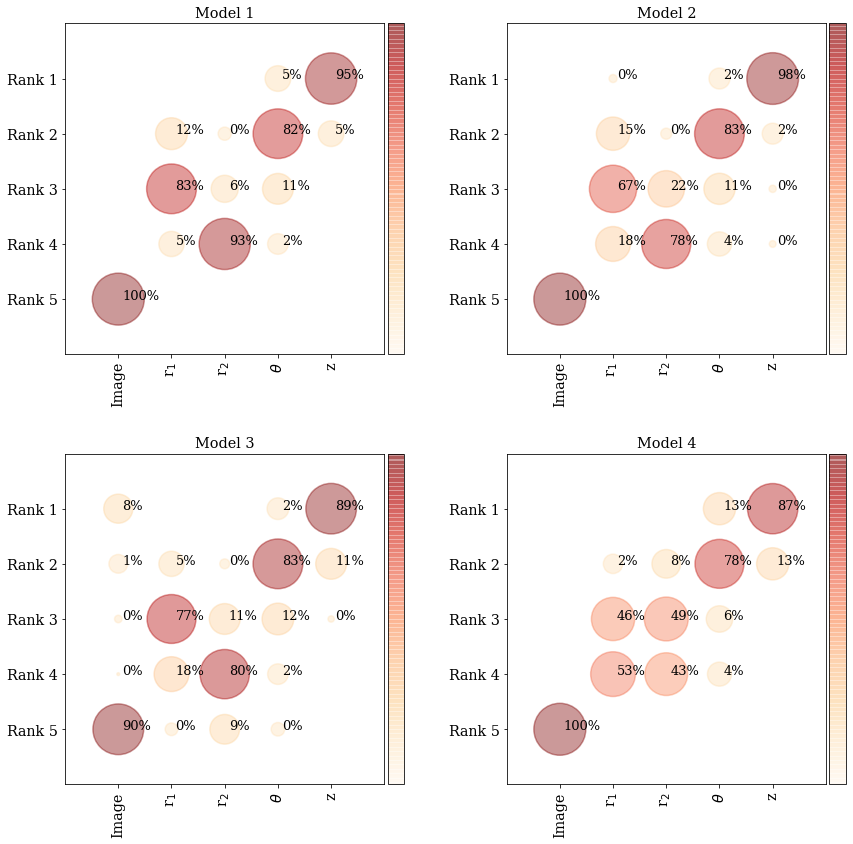

In [43]:
draw_bubbleplot((np.column_stack((np.sum(np.abs(norm_image_relevance1), axis=(1,2,3)), np.abs(norm_var_relevance1)))),
                (np.column_stack((np.sum(np.abs(norm_image_relevance2), axis=(1,2,3)), np.abs(norm_var_relevance2)))),
                (np.column_stack((np.sum(np.abs(norm_image_relevance3), axis=(1,2,3)), np.abs(norm_var_relevance3)))),
                (np.column_stack((np.sum(np.abs(norm_image_relevance4), axis=(1,2,3)), np.abs(norm_var_relevance4)))),
                ['Image', r'r$_1$', r'r$_2$', r'$\theta$', 'z'],
                ['Rank 5', 'Rank 4', 'Rank 3', 'Rank 2', 'Rank 1'])

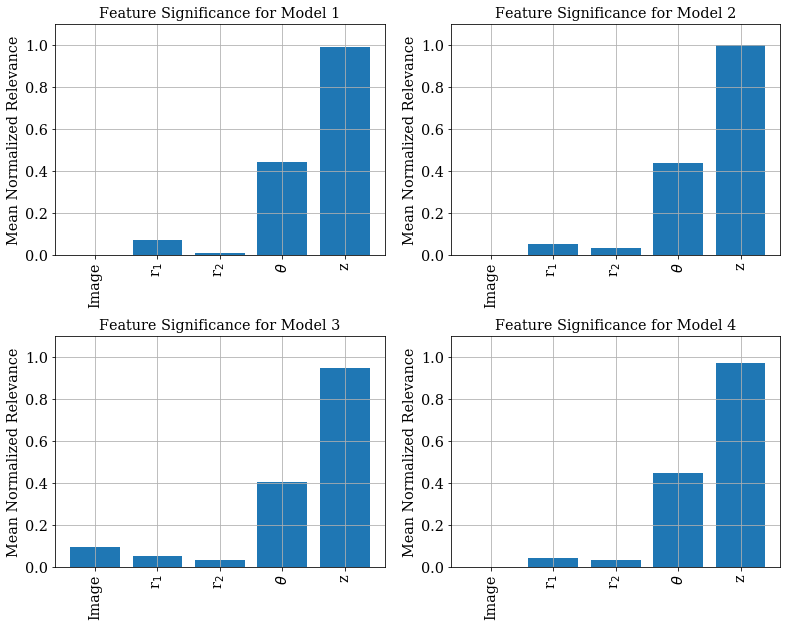

In [34]:
# for event wise normalised relevance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(13, 10))
fig.subplots_adjust(wspace =0.2, hspace =0.35)
axs=axs.flatten()
x = np.arange(5)
for i in range(len(axs)):
    if i==0:
        rel=np.append(np.array(np.mean(np.sum(np.abs(norm_image_relevance1), axis =(1,2,3)))), np.mean(np.abs(norm_var_relevance1), axis =0))
    elif i==1:
        rel=np.append(np.array(np.mean(np.sum(np.abs(norm_image_relevance2), axis =(1,2,3)))), np.mean(np.abs(norm_var_relevance2), axis =0))
    elif i==2:
        rel=np.append(np.array(np.mean(np.sum(np.abs(norm_image_relevance3), axis =(1,2,3)))), np.mean(np.abs(norm_var_relevance3), axis =0))
    else:
        rel=np.append(np.array(np.mean(np.sum(np.abs(norm_image_relevance4), axis =(1,2,3)))), np.mean(np.abs(norm_var_relevance4), axis =0))
    axs[i].bar(x, rel)
    axs[i].set_ylim(0, 1.1)
    axs[i].set_xticks(x)
    axs[i].set_ylabel('Mean Normalized Relevance')
    axs[i].set_xticklabels(['Image', r'r$_1$', r'r$_2$', r'$\theta$', 'z'], rotation=90)
    axs[i].set_title('Feature Significance for Model {}'.format(i+1))
    axs[i].grid()
plt.show()
fig.savefig('Toy_XAUG_featureSignificance_multimodel.png', bbox_inches='tight')

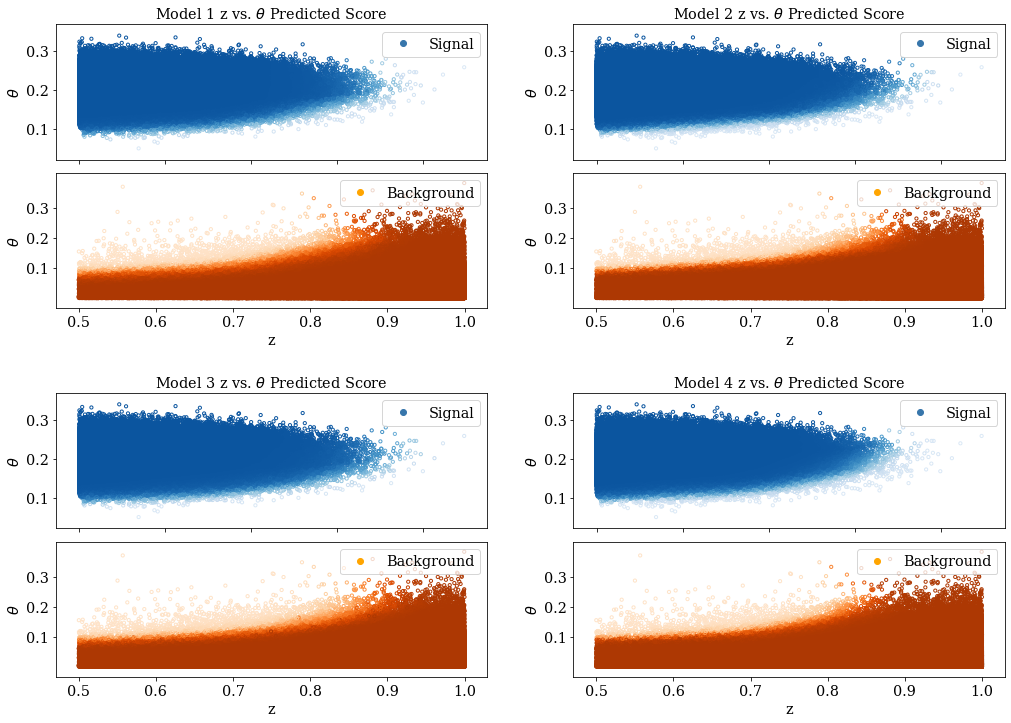

In [109]:
# for event wise normalised relevance
fig = plt.figure(figsize=(17, 12))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.3)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    if i==0:
        c1=(predict1[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict1[:,0][(data_test['labels'][:,0]==1)])
    elif i==1:
        c1=(predict2[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict2[:,0][(data_test['labels'][:,0]==1)])
    elif i==2:
        c1=(predict3[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict3[:,0][(data_test['labels'][:,0]==1)])
    else:
        c1=(predict4[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict4[:,0][(data_test['labels'][:,0]==1)])
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j==0:
            ax.set_title(r'Model {} z vs. $\theta$ Predicted Score'.format(i+1))
            ax.plot([], [], "o", color='#3776ab', label="Signal")
            g = ax.scatter(data_test['z'][(data_test['labels'][:,1]==1)].flatten(),
                       data_test['theta'][(data_test['labels'][:,1]==1)].flatten(),
                       s=10, vmin=-0.2, vmax=1.2, c = c1, cmap='Blues')
            g.set_facecolor('none')
            ax.set_xticklabels([])
            ax.legend(loc="upper right")
        else:
            ax.plot([], [], "o", color="orange", label="Background")
            g = ax.scatter(data_test['z'][(data_test['labels'][:,0]==1)].flatten(),
                       data_test['theta'][(data_test['labels'][:,0]==1)].flatten(),
                       s=10, vmin=-0.2, vmax=1.2, c = c2, cmap='Oranges')
            g.set_facecolor('none')
            ax.set_yticks([0.1, 0.2, 0.3])
            ax.set_xlabel('z')
            ax.legend(loc="upper right")
        ax.set_ylabel(r'$\theta$')
        fig.add_subplot(ax)
fig.show()
fig.savefig('Toy_XAUG_z_vs_theta_predict_overall.png', bbox_inches='tight')

0.0014655733 0.9999913 1.2075984e-05 1.0
4.274149e-07 1.0 1.5370993e-08 1.0
5.1840356e-08 0.9999944 5.720136e-06 1.0
1.8220223e-07 1.0 1.3731821e-08 1.0


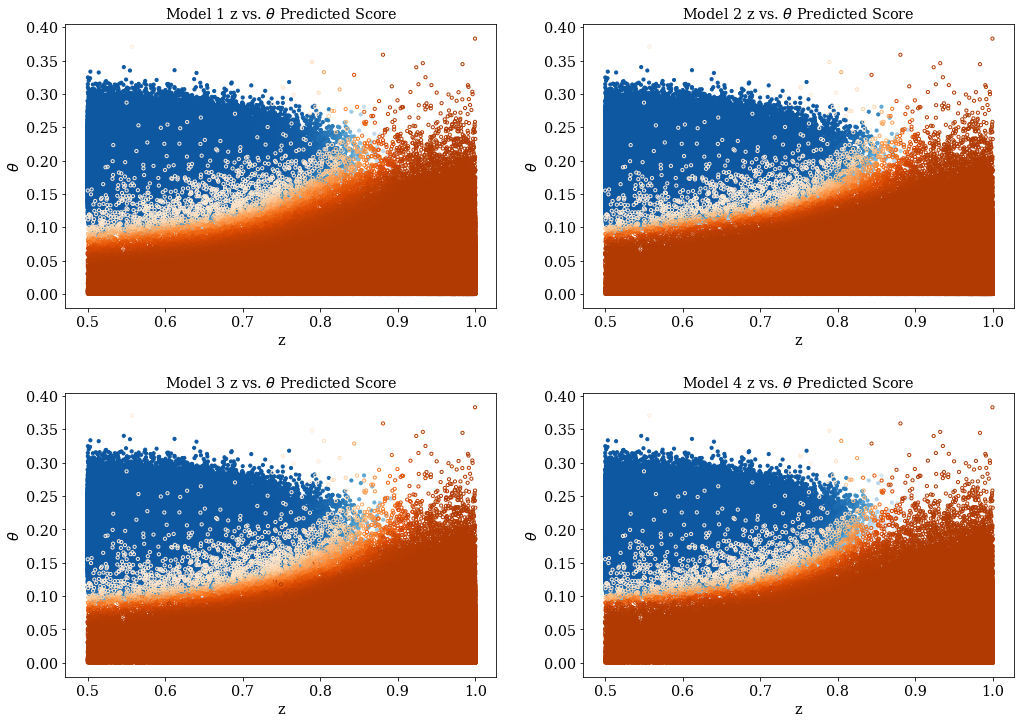

In [48]:
for event wise normalised relevance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 12))
fig.subplots_adjust(wspace =0.2, hspace =0.3)
axs=axs.flatten()
x = np.arange(5)

for i in range(len(axs)):
    if i==0:
        c1=(predict1[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict1[:,0][(data_test['labels'][:,0]==1)])
    elif i==1:
        c1=(predict2[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict2[:,0][(data_test['labels'][:,0]==1)])
    elif i==2:
        c1=(predict3[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict3[:,0][(data_test['labels'][:,0]==1)])
    else:
        c1=(predict4[:,1][(data_test['labels'][:,1]==1)])
        c2=(predict4[:,0][(data_test['labels'][:,0]==1)])
    g1 = axs[i].scatter(data_test['z'][(data_test['labels'][:,1]==1)].flatten(),
                   data_test['theta'][(data_test['labels'][:,1]==1)].flatten(),
                   s=10, vmin=-0.1, vmax=1.2, c = c1, cmap='Blues')
    g1 = axs[i].scatter(data_test['z'][(data_test['labels'][:,0]==1)].flatten(),
                   data_test['theta'][(data_test['labels'][:,0]==1)].flatten(),
                   s=10, vmin=-0.1, vmax=1.2, c = c2, cmap='Oranges')
    print(np.min(c1), np.max(c1), np.min(c2), np.max(c2))
    g1.set_facecolor('none') 
    g2.set_facecolor('none') 
    axs[i].set_xlabel('z')
    axs[i].set_ylabel(r'$\theta$')

    axs[i].set_title(r'Model {} z vs. $\theta$ Predicted Score'.format(i+1))
plt.show()
fig.savefig('Toy_XAUG_z_vs_theta_predict_overall.png', bbox_inches='tight')

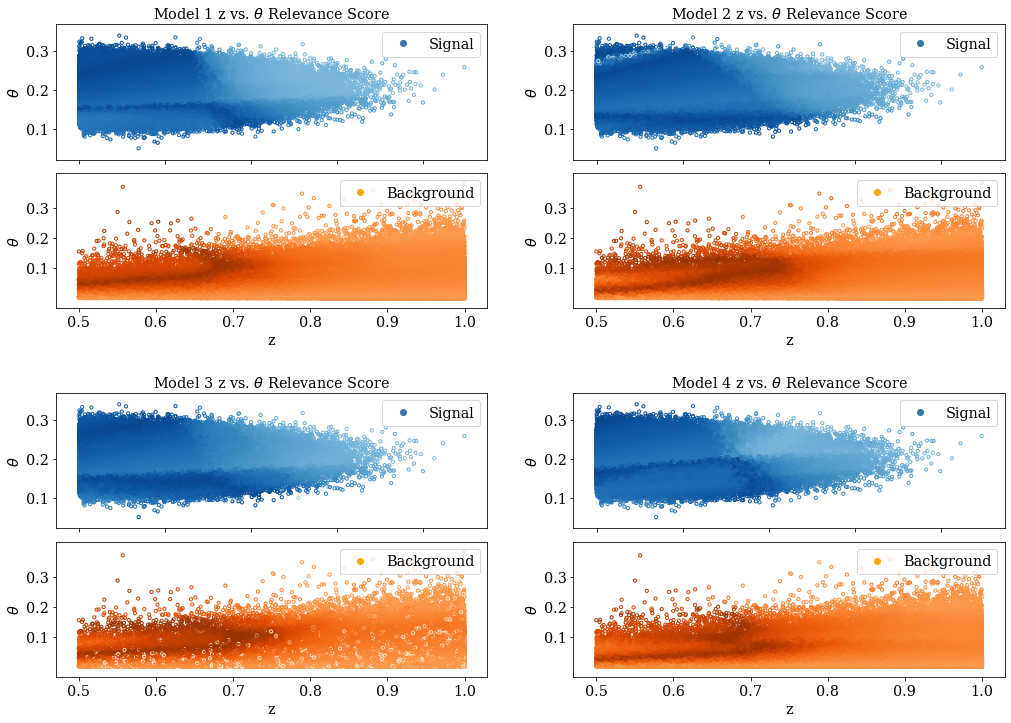

In [110]:
# for event wise normalised relevance
fig = plt.figure(figsize=(17, 12))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.3)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    if i==0:
        c1=(np.abs(norm_var_relevance1[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance1[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance1[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance1[:,2])[(data_test['labels'][:,0]==1)])
    elif i==1:
        c1=(np.abs(norm_var_relevance2[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance2[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance2[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance2[:,2])[(data_test['labels'][:,0]==1)])
    elif i==2:
        c1=(np.abs(norm_var_relevance3[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance3[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance3[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance3[:,2])[(data_test['labels'][:,0]==1)])
    else:
        c1=(np.abs(norm_var_relevance4[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance4[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance4[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance4[:,2])[(data_test['labels'][:,0]==1)])
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j==0:
            ax.set_title(r'Model {} z vs. $\theta$ Relevance Score'.format(i+1))
            ax.plot([], [], "o", color='#3776ab', label="Signal")
            g = ax.scatter(data_test['z'][(data_test['labels'][:,1]==1)].flatten(),
                       data_test['theta'][(data_test['labels'][:,1]==1)].flatten(),
                       s=10, vmin=0, vmax=2.2, c = c1, cmap='Blues')
            g.set_facecolor('none')
            ax.set_xticklabels([])
            ax.legend(loc="upper right")
        else:
            ax.plot([], [], "o", color="orange", label="Background")
            g = ax.scatter(data_test['z'][(data_test['labels'][:,0]==1)].flatten(),
                       data_test['theta'][(data_test['labels'][:,0]==1)].flatten(),
                       s=10, vmin=0, vmax=2.2, c = c2, cmap='Oranges')
            g.set_facecolor('none')
            ax.set_yticks([0.1, 0.2, 0.3])
            ax.set_xlabel('z')
            ax.legend(loc="upper right")
        ax.set_ylabel(r'$\theta$')
        fig.add_subplot(ax)
fig.show()
fig.savefig('Toy_XAUG_z_vs_theta_rel-z+theta_overall.png', bbox_inches='tight')

1.0000107 1.9999998 1.0000002 1.9999232
0.34585005 1.9999994 1.0000002 1.9998347
0.3475517 1.9999986 0.034865193 1.9999893
1.0000005 1.9999988 1.0000002 1.9999553


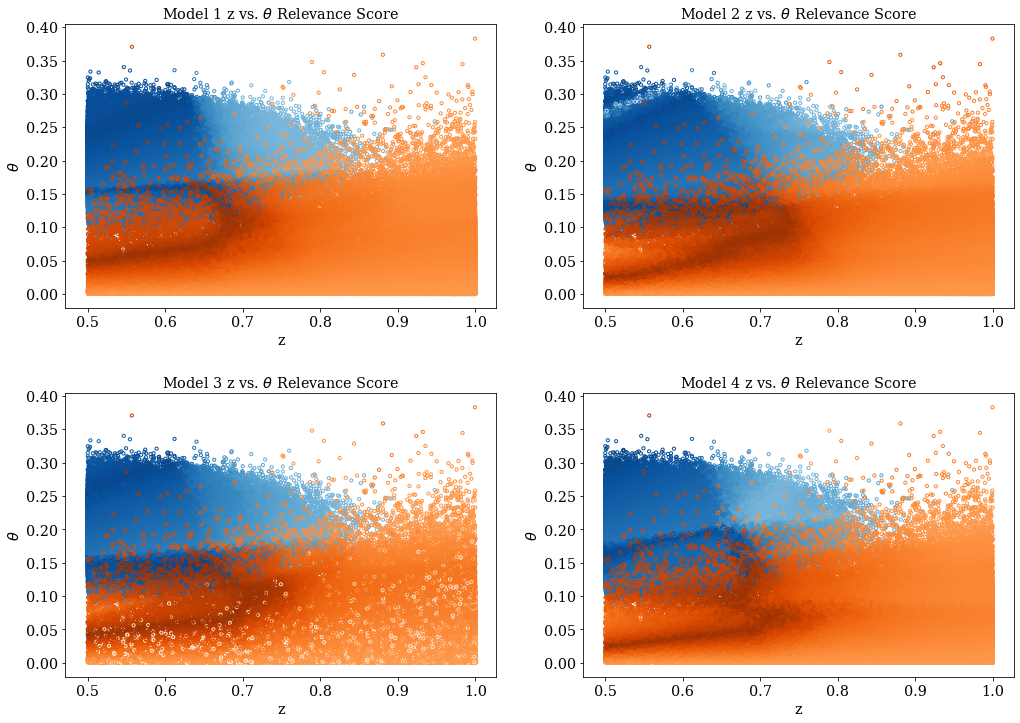

In [47]:
for event wise normalised relevance
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17, 12))
fig.subplots_adjust(wspace =0.2, hspace =0.3)
axs=axs.flatten()
x = np.arange(5)
for i in range(len(axs)):
    if i==0:
        c1=(np.abs(norm_var_relevance1[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance1[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance1[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance1[:,2])[(data_test['labels'][:,0]==1)])
    elif i==1:
        c1=(np.abs(norm_var_relevance2[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance2[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance2[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance2[:,2])[(data_test['labels'][:,0]==1)])
    elif i==2:
        c1=(np.abs(norm_var_relevance3[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance3[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance3[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance3[:,2])[(data_test['labels'][:,0]==1)])
    else:
        c1=(np.abs(norm_var_relevance4[:,3])[(data_test['labels'][:,1]==1)])+(np.abs(norm_var_relevance4[:,2])[(data_test['labels'][:,1]==1)])
        c2=(np.abs(norm_var_relevance4[:,3])[(data_test['labels'][:,0]==1)])+(np.abs(norm_var_relevance4[:,2])[(data_test['labels'][:,0]==1)])
    g2 = axs[i].scatter(data_test['z'][(data_test['labels'][:,1]==1)].flatten(),
                   data_test['theta'][(data_test['labels'][:,1]==1)].flatten(),
                   s=10, vmin=0, vmax=2.2, c = c1, cmap='Blues')
    g1 = axs[i].scatter(data_test['z'][(data_test['labels'][:,0]==1)].flatten(),
                   data_test['theta'][(data_test['labels'][:,0]==1)].flatten(),
                   s=10, vmin=0, vmax=2.2, c = c2, cmap='Oranges') #norm=SymLogNorm(linthresh=0.01)
    g1.set_facecolor('none') 
    g2.set_facecolor('none') 
    print(np.min(c1), np.max(c1), np.min(c2), np.max(c2))
    axs[i].set_xlabel('z')
    axs[i].set_ylabel(r'$\theta$')

    axs[i].set_title(r'Model {} z vs. $\theta$ Relevance Score'.format(i+1))
plt.show()
fig.savefig('Toy_XAUG_z_vs_theta_rel-z+theta_overall.png', bbox_inches='tight')

In [49]:
def plot_profile(sig_hist, bkg_hist, tp_sig, tn_bkg, tp_relevance, tn_relevance, bins, xlabel, maxy):
    '''
    sig_hist: array of a variable for signal that will be plotted as hist on top
    bkg_hist: array of a variable for bkg that will be plotted as hist on top
    tp_sig: array of a variable for true positive (signal) case
    tn_sig: array of a variable for true negatice (bkg) case
    tp_relevance: array of relevance for a variable for true positive (signal) case
    tn_relevance: array of relevance for a variable for true negative (bkg) case
    bins: number of bins
    xlabel: string of xlabel
    maxy: y range for relevance plot (-maxy, maxy)
    '''

    gs=GridSpec(3,1)
    ax1=fig.add_subplot(gs[:2,:])
    ax2=fig.add_subplot(gs[2,:])

    bin_means, bin_edges, binnumber = stats.binned_statistic(tp_sig.flatten(), tp_relevance.flatten(),
                                                             statistic='mean', bins=bins)
    bin_std, _, _ = stats.binned_statistic(tp_sig.flatten(), tp_relevance.flatten(), statistic='std', bins=bins)
    
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    ax2.plot(bin_centers,bin_means, '#1f77b4', lw=2,label='Signal')
    ax2.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color = '#1f77b4', alpha = 0.2)

    bin_means, bin_edges, binnumber = stats.binned_statistic(tn_bkg.flatten(),tn_relevance.flatten(),
                                                             statistic='mean', bins=bins)
    bin_std, _, _ = stats.binned_statistic(tn_bkg.flatten(), tn_relevance.flatten(), statistic='std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    ax2.plot(bin_centers,bin_means, '#ff7f0e', lw=2,label='Background')
    ax2.fill_between(bin_centers, bin_means - bin_std, bin_means + bin_std, color = '#ff7f0e', alpha = 0.2)


    ax1.hist(sig_hist, normed=False,weights = np.ones(len(sig_hist.flatten()))/len(sig_hist.flatten()),
             histtype='step', alpha=0.55, facecolor='#1f77b4', bins=bins, lw=2,
             label='Signal', hatch='/', edgecolor='k', fill=True)
    
    ax1.hist(bkg_hist, normed=False, weights = np.ones(len(bkg_hist.flatten()))/len(bkg_hist.flatten()),
            histtype='step',alpha=0.55, facecolor='#ff7f0e', bins=bins, lw=2,
            label='Background', hatch='\\', edgecolor='k', fill=True)
    minx= np.min([np.min(sig_hist.flatten()), np.min(bkg_hist.flatten())])
    maxx= np.max([np.max(sig_hist.flatten()), np.max(bkg_hist.flatten())])
    ax1.set_xlim(minx,maxx)
    ax1.legend(loc='upper center')
    ax1.set_ylabel('Fraction')
    ax2.set_ylabel('Relevance')
    ax2.set_xlabel(xlabel)
    ax2.set_xlim(minx,maxx)
    ax2.set_ylim(-maxy,maxy)
    ax2.plot([minx,maxx],[0,0],'--k')
    ax1.set_xticklabels([])
    plt.tight_layout()
    plt.show()

For plotting profiles we take an eventwise average of the relevance values obtained from 4 seperately trained models.

In [50]:
var_rel=0.25*(norm_var_relevance1+norm_var_relevance2+norm_var_relevance3+norm_var_relevance4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


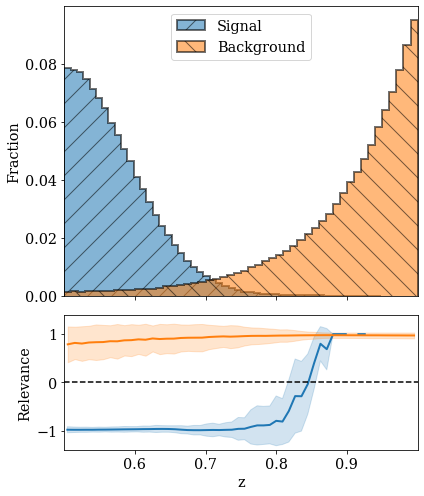

In [51]:
fig=plt.figure(figsize=(6,7))
plot_profile(data_test['z'][(data_test['labels'][:,1]==1)],
             data_test['z'][(data_test['labels'][:,0]==1)],
             data_test['z'][(data_test['labels'][:,1]==1)], data_test['z'][(data_test['labels'][:,0]==1)],
             var_rel[:,3][(data_test['labels'][:,1]==1)], var_rel[:,3][(data_test['labels'][:,0]==1)], 50, 'z', 1.4)
fig.savefig('Toy_XAUG_z_profile_overall.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


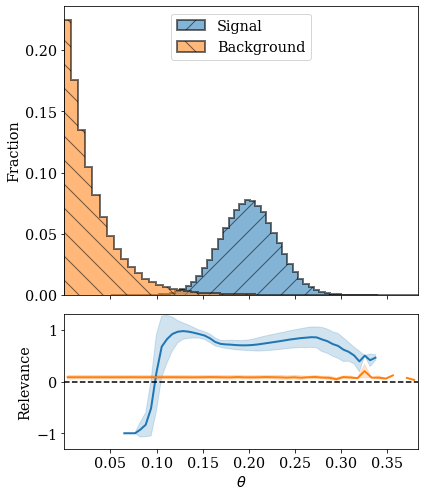

In [57]:
fig=plt.figure(figsize=(6,7))
plot_profile(data_test['theta'][(data_test['labels'][:,1]==1)],
             data_test['theta'][(data_test['labels'][:,0]==1)],
             data_test['theta'][(data_test['labels'][:,1]==1)], data_test['theta'][(data_test['labels'][:,0]==1)],
             var_rel[:,2][(data_test['labels'][:,1]==1)], var_rel[:,0][(data_test['labels'][:,1]==1)], 50, r'$\theta$', 1.3)
fig.savefig('Toy_XAUG_theta_profile_ovarall.png', bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


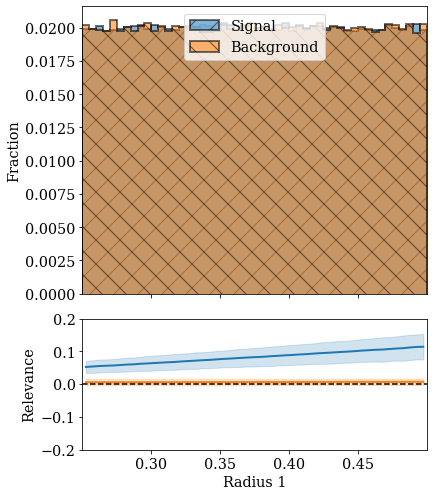

In [63]:
fig=plt.figure(figsize=(6,7))
plot_profile(data_test['radii'][:,0][(data_test['labels'][:,1]==1)],
             data_test['radii'][:,0][(data_test['labels'][:,0]==1)],
             data_test['radii'][:,0][(data_test['labels'][:,1]==1)], data_test['radii'][:,0][(data_test['labels'][:,0]==1)],
             var_rel[:,0][(data_test['labels'][:,1]==1)], var_rel[:,1][(data_test['labels'][:,0]==1)], 50, 'Radius 1', 0.20)
fig.savefig('Toy_XAUG_r1_profile_overall.png', bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


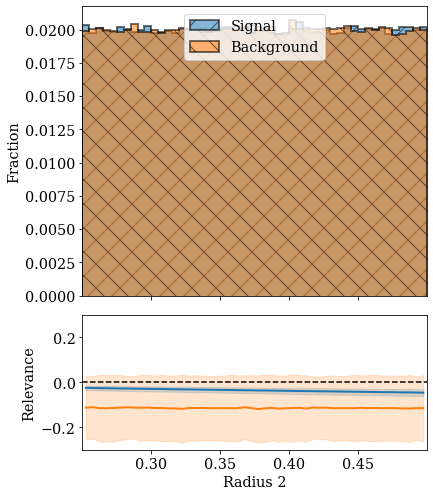

In [67]:
fig=plt.figure(figsize=(6,7))
plot_profile(data_test['radii'][:,1][(data_test['labels'][:,1]==1)],
             data_test['radii'][:,1][(data_test['labels'][:,0]==1)],
             data_test['radii'][:,1][(data_test['labels'][:,1]==1)], data_test['radii'][:,1][(data_test['labels'][:,0]==1)],
             var_rel[:,1][(data_test['labels'][:,1]==1)], var_rel[:,2][(data_test['labels'][:,0]==1)], 50, 'Radius 2', 0.3)
fig.savefig('Toy_XAUG_r2_profile_model1_norm.png', bbox_inches='tight')